In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
    
def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    
    return run_query(q)

    


In [2]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [3]:
q = '''
WITH 
    tracks_usa AS
        (SELECT g.name Genre, count(i.invoice_id) tracks_sold
         FROM invoice i
         INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
         INNER JOIN track t ON t.track_id = il.track_id
         INNER JOIN genre g ON g.genre_id = t.genre_id
         WHERE billing_country = 'USA'
         GROUP BY g.name
         
         ) ,
    summing_tracks AS
        (
         SELECT SUM(tracks_sold) sum_sold
         FROM tracks_usa
         )
SELECT t.*, CAST(t.tracks_sold as float) / CAST((SELECT sum_sold from summing_tracks) as float) Proportion
FROM tracks_usa t
ORDER BY t.tracks_sold DESC

LIMIT 10
    
'''
tracks_per_genre = run_query(q)

In [4]:
tracks_per_genre

,Genre,tracks_sold,Proportion
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


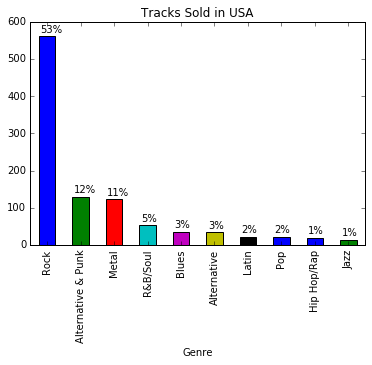

In [5]:
tracks_per_genre.set_index("Genre",drop=True,inplace=True)
tracks_per_genre['tracks_sold'].plot.bar(title='Tracks Sold in USA')

for i, label in enumerate(list(tracks_per_genre.index)):
    score = tracks_per_genre.loc[label, "tracks_sold"]
    label = (tracks_per_genre.loc[label, "Proportion"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), ( i-.2 ,score + 10))

plt.show()


Based on the information above I would suggest that Chinook add albums by 'Red Tone', 'Slim Jim Bites', and 'Meteor and the Girls'

In [6]:
q = '''
SELECT e.employee_id,e.first_name||' '||e.last_name employee_name, c.customer_id, SUM(i.total) sales
FROM employee e
INNER JOIN customer c ON c.support_rep_id = e.employee_id
INNER JOIN invoice i ON i.customer_id = c.customer_id
GROUP BY e.employee_id
'''
employee_sales = run_query(q)

In [7]:
employee_sales

,employee_id,employee_name,customer_id,sales
0,3,Jane Peacock,53,1731.51
1,4,Margaret Park,20,1584.00
2,5,Steve Johnson,14,1393.92


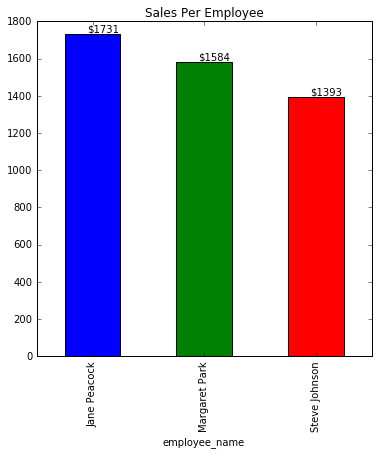

In [8]:
employee_sales.set_index('employee_name',inplace = True)
employee_sales['sales'].plot.bar(title='Sales Per Employee',figsize=(6,6))

for i, label in enumerate(list(employee_sales.index)):
    score = employee_sales.loc[label,'sales'].astype(int)
    plt.annotate('$'+str(score), ( i-.05 ,score + 10))

In [9]:
c = '''
CREATE VIEW 
    country_data AS
    SELECT c.country, c.customer_id, i.total, i.invoice_id
     FROM customer c
     LEFT JOIN invoice i ON i.customer_id = c.customer_id
     


'''
run_command(c)



OperationalError: table country_data already exists

In [10]:
c = '''
CREATE VIEW sales_customers AS
    SELECT  country, COUNT(DISTINCT(customer_id)) number_of_customers, SUM(total) total_sales,
        CAST(SUM(total) AS float) / CAST(COUNT(DISTINCT(customer_id)) AS float) avg_per_cust,
        AVG(total) avg_order_val
    FROM country_data
    GROUP BY country
'''

run_command(c)

OperationalError: table sales_customers already exists

In [11]:
q = '''
WITH country_or_other AS
        (
        SELECT 
            CASE
                WHEN sc.number_of_customers = 1 THEN "Other"
                ELSE sc.country
            END AS country,
            sc.number_of_customers,
            sc.total_sales,
            sc.avg_per_cust,
            sc.avg_order_val
    
            FROM sales_customers sc
            ORDER BY sc.number_of_customers DESC
        ) ,

    count_other AS
        (
         SELECT co.country, 
             SUM(co.number_of_customers) number_of_customers, 
             SUM(co.total_sales) total_sales, 
             AVG(co.avg_per_cust) avg_per_cust,
             AVG(co.avg_order_val) avg_order_val
         FROM country_or_other co
         GROUP BY country
       )
       
SELECT country, number_of_customers,total_sales, avg_per_cust, avg_order_val
    FROM
    (
    SELECT co.*,
    
        CASE 
            WHEN co.country = "Other" THEN 1
            ELSE 0
        END AS sort 

    FROM count_other co
    )
ORDER BY sort, number_of_customers DESC


'''
data_cust = run_query(q)
data_cust

,country,number_of_customers,total_sales,avg_per_cust,avg_order_val
0,USA,13,1040.49,80.037692,7.942672
1,Canada,8,535.59,66.948750,7.047237
2,Brazil,5,427.68,85.536000,7.011148
3,France,5,389.07,77.814000,7.781400
4,Germany,4,334.62,83.655000,8.161463
5,United Kingdom,3,245.52,81.840000,8.768571
6,Czech Republic,2,273.24,136.620000,9.108000
7,India,2,183.15,91.575000,8.721429
8,Portugal,2,185.13,92.565000,6.383793
9,Other,15,1094.94,72.996000,7.445071


In [12]:
data_cust.set_index('country',inplace=True)



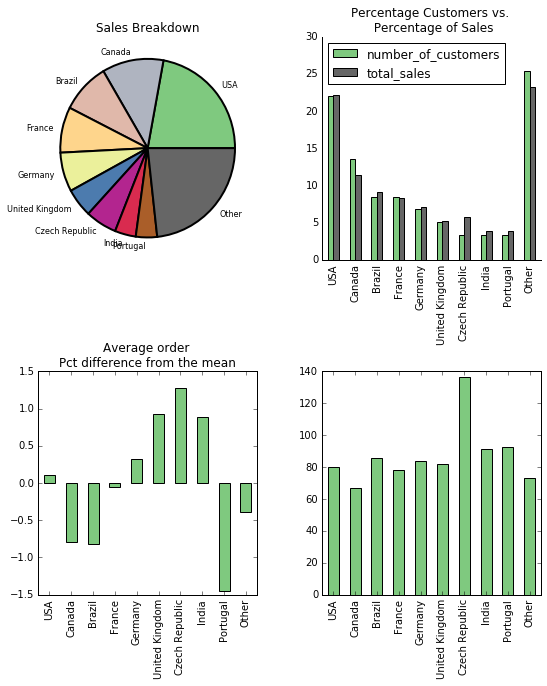

In [13]:
fig, ax = plt.subplots(nrows = 2, ncols = 2,figsize=(9,10))
ax1, ax2, ax3, ax4 = ax.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)

#Sales Breakdown
sales_breakdown = data_cust['total_sales'].rename('')
sales_breakdown.plot.pie(
    ax = ax1, 
    use_index=True, 
    title='Sales Breakdown',
    colormap=plt.cm.Accent,
    wedgeprops = {'linewidth': 2},
    fontsize=8,

    
)
#Percentage of Customers vs. Percentage of Sales
cvs_cols = ['number_of_customers','total_sales']
cvs_df = data_cust[['number_of_customers','total_sales']].copy()
cvs_df.index.name = ''
for c in cvs_cols:
    cvs_df[c] /= cvs_df[c].sum()
    cvs_df[c] *= 100
cvs_df.plot.bar(
    ax=ax2,
    colormap=plt.cm.Accent,
    title='Percentage Customers vs. \n Percentage of Sales')
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

#Average order Pct difference from the mean

avg_diff = data_cust.avg_order_val.copy()
avg_diff.index.name = ''
mean_diff = avg_diff.mean()
avg_diff -= mean_diff
avg_diff.plot.bar(
    ax=ax3,
    title='Average order \nPct difference from the mean',
    colormap=plt.cm.Accent)

#Average per customer
ltv = data_cust.avg_per_cust.copy()
ltv.index.name = ''
ltv.plot.bar(
    ax = ax4,
    colormap = plt.cm.Accent)




Based on the data, there may be opportunity in the following countries:

Czech Republic,
United Kingdom,
India.
It's worth keeping in mind that because the amount of data from each of these countries is relatively low. Because of this, we should be cautious spending too much money on new marketing campaigns, as the sample size is not large enough to give us high confidence. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.

In [75]:
q = '''
WITH 
    invoice_track AS 
(
    SELECT il.invoice_id, a.album_id, t.track_id
    FROM invoice_line il
    INNER JOIN track t ON t.track_id = il.track_id
    INNER JOIN album a ON a.album_id = t.album_id
) ,
    first_track_invoice AS
(

    SELECT il.invoice_id, MIN(il.track_id) first_track
    FROM invoice_line il
    GROUP BY invoice_id
)
SELECT
purchase,COUNT(invoice_id) num_of_invoices, CAST(COUNT(*) AS float) / (SELECT COUNT) per_invoice

FROM(
    SELECT fti.*,
        CASE
            WHEN(
                SELECT il2.track_id FROM invoice_line il2
                WHERE il2.invoice_id = fti.invoice_id
            EXCEPT
                SELECT t.track_id FROM track t
                WHERE album_id = (SELECT t2.album_id FROM track t2
                WHERE t2.track_id = fti.first_track)
                )IS NULL
            AND(
                SELECT t.track_id FROM track t
                WHERE album_id = (SELECT t2.album_id FROM track t2
                WHERE t2.track_id = fti.first_track)
            EXCEPT
                SELECT il2.track_id FROM invoice_line il2
                WHERE il2.invoice_id = fti.invoice_id

                )IS NULL
            THEN 'yes'
            ELSE 'no'
        END AS 'purchase'
    FROM first_track_invoice fti
    )

GROUP BY purchase
'''
test = run_query(q)

In [76]:
test

,purchase,num_of_invoices,per_invoice
0,no,500,1.0
1,yes,114,1.0
